In [1]:
""" Python Standard Library """
import os
import datetime as dt

import json
import logging
""" Third Party Imports """
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
""" Local Imports """
if 'requirements.txt' not in os.listdir(os.getcwd()):
    os.chdir(os.path.join('..','..','..'))
print(os.getcwd())
from covid_model import CovidModel
from covid_model.runnable_functions import do_single_fit, do_create_report
from covid_model.utils import setup, get_filepath_prefix
from covid_model.analysis.charts import plot_transmission_control

os.environ['gcp_project'] = 'co-covid-models'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "co-covid-models-credentials.json"

outdir = setup("variant_share_qc.ipynb")

/Users/brittneycontreras/PycharmProjects/covid-models


2022/08/29 10:00:37 INFO|============================================================


In [74]:
import pandas as pd
obs_fpath = "covid_model/model_dev_qc/variants/CDPHE Variant Data (manually transcribed and limited to model variants).csv"
obs = pd.read_csv(obs_fpath, parse_dates=['Date']).fillna(0)
obs['Date'] = [d.date() for d in obs['Date']]
obs = obs.set_index('Date')

In [3]:
seeds = [
    {"param": "omicron_seed", "attrs": None, "vals": {"2020-01-01": 0, "2021-11-09": 1, "2021-12-11": 0}, "desc": "1 BA.1 seed is planted each day starting November 9th, 2021 and ending December 11th, 2021"},
    {"param": "ba2_seed", "attrs": None, "vals": {"2020-01-01": 0, "2021-12-23": 5, "2022-02-02": 0}, "desc": "5 BA.2 seeds are planted each day starting December 23rd, 2021 and ending February 2nd, 2022"},
    {"param": "ba2121_seed", "attrs": None, "vals": {"2020-01-01": 0, "2022-02-27": 5, "2022-04-08": 0}, "desc": "5 BA.2.12.1 seeds are planted each day starting February 27th, 2022 and ending April 8th, 2022"},
    {"param": "ba45_seed", "attrs": None, "vals": {"2020-01-01": 0, "2022-04-05": 5, "2022-05-15": 0}, "desc": "5 BA.4/5 seeds are planted each day started April 5th, 2022 and ending May 15, 2022"},
    {"param": "immune_escape", "from_attrs": {"variant": "none", "immun": "weak"},  "to_attrs": {"variant": "delta"}, "vals": {"2020-01-01": 0.375}, "desc": "37.5% of weakly immune individuals can get reinfected with Delta"},
    {"param": "immune_escape", "from_attrs": {"immun": "strong", "variant": ["none", "wildtype", "alpha", "delta"]}, "to_attrs": {"variant": ["omicron", "ba2", "ba2121"]}, "vals": {"2020-01-01": 0.1}, "desc": "given prior infection with a pre-Omicron variant, 10% of strongly immune individuals can get reinfected with BA.1, BA.2, or BA.2.12.1"},
    {"param": "immune_escape", "from_attrs": {"immun": "weak", "variant": ["none", "wildtype", "alpha", "delta"]}, "to_attrs": {"variant": ["omicron", "ba2", "ba2121"]}, "vals": {"2020-01-01": 0.75}, "desc": "given prior infection with a pre-Omicron variant, 75% of weakly immune individuals can get reinfected with BA.1, BA.2, or BA.2.12.1"},
    {"param": "immune_escape", "from_attrs": {"immun": "strong", "variant": ["omicron", "ba2"]}, "to_attrs": {"variant": ["ba2121"]}, "vals": {"2020-01-01": 0.03}, "desc": "given prior infection with BA.1 or BA.2, 3% of strongly immune individuals can get reinfected with BA.2.12.1"},
    {"param": "immune_escape", "from_attrs": {"immun": "weak", "variant": ["omicron", "ba2"]}, "to_attrs": {"variant": ["ba2121"]}, "vals": {"2020-01-01": 0.25}, "desc": "given prior infection with BA.1 or BA.2, 25% of weakly immune individuals can get reinfected with BA.2.12.1"},
    {"param": "immune_escape", "from_attrs": {"immun": "strong", "variant": ["none", "wildtype", "alpha", "delta"]}, "to_attrs": {"variant": ["ba45"]}, "vals": {"2020-01-01": 0.15}, "desc": "given prior infection with a pre-Omicron variant, 15% of strongly immune individuals can get reinfected with BA.4/5"},
    {"param": "immune_escape", "from_attrs": {"immun": "weak", "variant": ["none", "wildtype", "alpha", "delta"]}, "to_attrs": {"variant": ["ba45"]}, "vals": {"2020-01-01": 0.80}, "desc": "given prior infection with a pre-Omicron variant, 80% of weakly immune individuals can get reinfected with BA.4/5"},
    {"param": "immune_escape", "from_attrs": {"immun": "strong", "variant": ["omicron", "ba2", "ba2121"]}, "to_attrs": {"variant": ["ba45"]}, "vals": {"2020-01-01": 0.04}, "desc": "given prior infection with an Omicron variant, 4% of strongly immune individuals can get reinfected with BA.4/5"},
    {"param": "immune_escape", "from_attrs": {"immun": "weak", "variant": ["omicron", "ba2", "ba2121"]}, "to_attrs": {"variant": ["ba45"]}, "vals": {"2020-01-01": 0.40}, "desc": "given prior infection with an Omicron variant, 40% of weakly immune individuals can get reinfected with BA.4/5"},
    {"param": "severe_immunity", "attrs": {"immun": ["strong", "weak"]}, "vals": {"2020-01-01": 0.975}, "desc": "97.5% of people with some level of immunity are protected against severe disease"},
    {"param": "severe_immunity", "attrs": {"immun": ["strong", "weak"], "vacc": "none"}, "vals": {"2020-01-01": 0.5}, "desc": "unvaccinated individuals whose immunity was conferred by natural infection have 47.5% less protection against severe disease than those whose strong or weak immunity was conferred by vaccination"},
    {"param": "severe_immunity", "attrs": {"variant": "delta"}, "mults": {"2020-01-01": 0.9}, "desc": "90% of people with a prior Delta infection are protected against severe disease"},
    {"param": "severe_immunity", "attrs": {"vacc": ["shot1", "shot2"], "variant": ["omicron", "ba2", "ba2121", "ba45"]}, "mults": {"2020-01-01": 0.7}, "desc": "70% of people who have completed a vaccine series are protected against severe Omicron"},
    {"param": "severe_immunity", "attrs": {"vacc": ["booster1", "booster2"], "variant": ["omicron", "ba2", "ba2121", "ba45"]}, "mults": {"2020-01-01": 0.9}, "desc": "90% of people who have been boosted are protected against severe Omicron"},
]

model_args = {
    'params_defs': json.load(open('covid_model/model_dev_qc/qc_params.json')) + seeds,
    'region_defs': 'covid_model/input/region_definitions.json',
    'vacc_proj_params': 'covid_model/input/vacc_proj_params.json',
    'regions': ['co'],
    'mobility_mode': None,
    'start_date': '2020-01-24',
    'end_date': '2022-10-15',
    'max_step_size': 1.0,
    'ode_method': 'RK45',
    'hosp_reporting_frac': {"2020-01-01": 1, "2022-03-01": 0.932, "2022-03-15": 0.868, "2022-03-30": 0.8}
}
model_args = {'base_spec_id': 3470, #model.spec_id
              'update_data': False}
fit_args = {
    #'fit_start_date': '2022-3-01',
    #'fit_end_date': '2022-05-01',
    'tc_min': 0.0,
    'tc_max': 0.999,
    'tc_window_size': 14,
    'tc_window_batch_size': 6,
    'tc_batch_increment': 2,
    'last_tc_window_min_size': 14,
    'outdir': outdir
}
model = CovidModel(**model_args)
model.prep(outdir=outdir)

2022/08/29 10:00:49 INFO|----------------------|{'fit_batch': '24', 'run_type': 'fit'} Prepping Model


In [4]:
#model.solve_seir()
model = do_single_fit(**fit_args, base_model = model, prep_model=False)

2022/08/29 10:02:21 INFO|-------------------------|{'fit_batch': '24', 'run_type': 'fit'} Retrieving vaccinations data
2022/08/29 10:02:28 INFO|-------------------------|{'fit_batch': '24', 'run_type': 'fit'} Constructing vaccination projections
2022/08/29 10:02:28 INFO|-------------------------|{'fit_batch': '24', 'run_type': 'fit'} Retrieving hospitalizations data
2022/08/29 10:02:41 INFO|----------------------|{'fit_batch': '24', 'run_type': 'fit'} Will fit 32 times
2022/08/29 10:08:32 INFO|----------------------|{'fit_batch': '0', 'run_type': 'fit'}: Transmission control fit 1/32 completed in 351.387257083 seconds: {0: {'co': 0.8773342621522588}, 14: {'co': 0.6831243785212967}, 28: {'co': 0.5407707355230232}, 42: {'co': 0.0005018151563890939}, 56: {'co': 0.681610378323963}, 70: {'co': 0.89119609749355}}
2022/08/29 10:08:32 INFO|-----------------------|{'fit_batch': '0', 'run_type': 'fit'}: Running forward sim
2022/08/29 10:09:50 INFO|----------------------|{'fit_batch': '1', 'run_t

2022/08/29 10:30:15 INFO|-----------------------|{'fit_batch': '16', 'run_type': 'fit'}: Running forward sim
2022/08/29 10:31:08 INFO|----------------------|{'fit_batch': '17', 'run_type': 'fit'}: Transmission control fit 18/32 completed in 51.67409037499988 seconds: {476: {'co': 0.8003383981497408}, 490: {'co': 0.8385912881635088}, 504: {'co': 0.7984061970662919}, 518: {'co': 0.7902684146404934}, 532: {'co': 0.7772119610442282}, 546: {'co': 0.7162954332516448}}
2022/08/29 10:31:08 INFO|-----------------------|{'fit_batch': '17', 'run_type': 'fit'}: Running forward sim
2022/08/29 10:32:03 INFO|----------------------|{'fit_batch': '18', 'run_type': 'fit'}: Transmission control fit 19/32 completed in 53.34593054200013 seconds: {504: {'co': 0.7977161904574006}, 518: {'co': 0.7923906761482328}, 532: {'co': 0.7713246139013795}, 546: {'co': 0.726126724178468}, 560: {'co': 0.7583945875216385}, 574: {'co': 0.753757107237453}}
2022/08/29 10:32:03 INFO|-----------------------|{'fit_batch': '18',

2022/08/29 10:51:23 INFO|-----------------------|{'fit_batch': '31', 'run_type': 'fit'}: Running forward sim
2022/08/29 10:51:25 INFO|----------------------|{'fit_batch': '31', 'run_type': 'fit'}: Uploading final results
2022/08/29 10:51:31 INFO|----------------------|{'fit_batch': '31', 'run_type': 'fit'}: spec_id: 3559


In [5]:
model.solve_seir()
soln = model.solution_sum_df(['seir', 'variant'])

In [26]:
start_date = dt.datetime.strptime('2020-01-24', '%Y-%m-%d').date()
end_date = dt.datetime.strptime('2022-07-03', '%Y-%m-%d').date()
rows = (soln.index.get_level_values(0) >= start_date) & (soln.index.get_level_values(0) <= end_date)
cols = [any(colname == seir for seir in ['Ih', 'I', 'A']) for colname in soln.columns.get_level_values(0)]
infected_by_variant = soln.loc[rows, cols].groupby('variant', axis=1).sum()

<AxesSubplot:xlabel='date'>

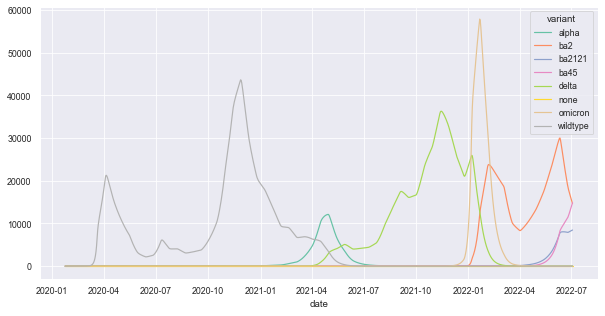

In [27]:
infected_by_variant.plot(figsize=(10, 5), cmap='Set2')

<AxesSubplot:xlabel='date'>

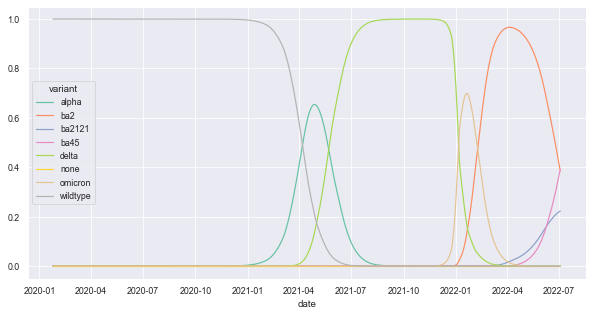

In [28]:
infected_by_variant.div(infected_by_variant.sum(axis=1), axis=0).plot(figsize=(10, 5), cmap='Set2')

<AxesSubplot:xlabel='Date'>

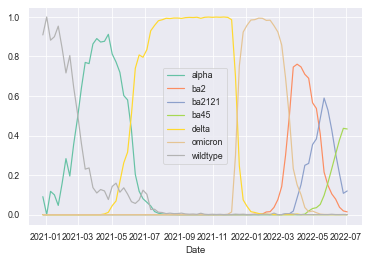

In [55]:
new_obs.plot(cmap='Set2')

In [29]:
# Saves data from plot above to .csv file - may need to update file path and name depending on preferences
new_infected_by_variant = infected_by_variant.div(infected_by_variant.sum(axis=1), axis=0)
new_df = pd.DataFrame(new_infected_by_variant)
new_df.to_csv('./norm_variant_prev.csv')

<AxesSubplot:xlabel='Date'>

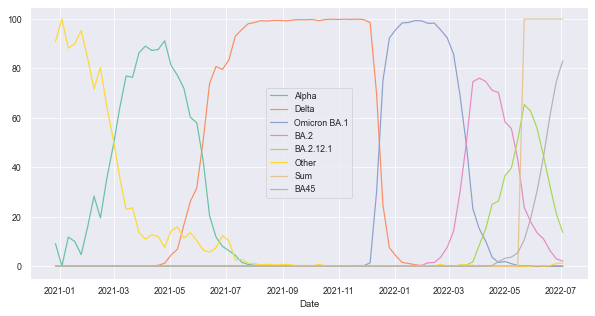

In [75]:
obs_rows = (obs.index.values >= start_date) & (obs.index.values <= end_date)
obs['BA45'] = obs['BA.4'] + obs['BA.5']
obs = obs.drop(columns=['BA.4', 'BA.5']).loc[obs_rows,]
obs.plot(figsize=(10,5), cmap='Set2')

<AxesSubplot:xlabel='date'>

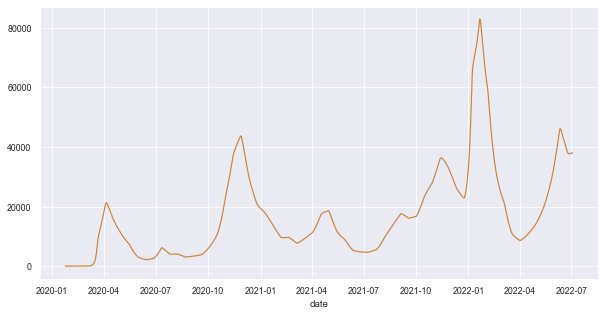

In [65]:
infected_by_variant.sum(axis=1).plot(figsize=(10, 5))

<AxesSubplot:xlabel='region,date'>

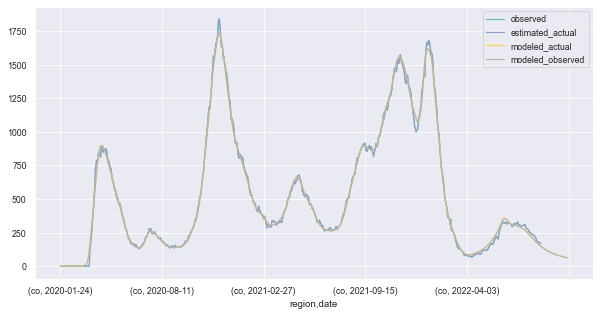

In [67]:
model.modeled_vs_observed_hosps().plot(figsize=(10,5), cmap='Set2')

In [ ]:
do_create_report(model, outdir)

### Make figure plot comparing cdc data and model variant share for each variant seperately

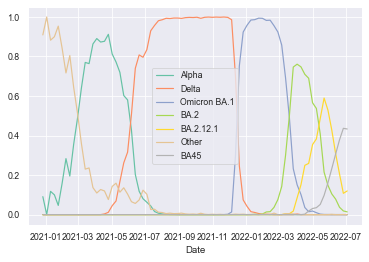

In [72]:
# Clean up obs data under new df (new_obs) to make plotting easier

# Normalize observed data
new_obs = obs.div(obs.sum(axis=1), axis=0)
# Get rid of seperate BA.4 and BA.5 columns
new_obs = new_obs.drop(columns=['BA.4', 'BA.5'])
# Change column labels to match those of our model column labels
new_obs.plot(cmap='Set2')
new_obs = new_obs.rename(columns={"Alpha":"alpha", "Delta":"delta", "Omicron BA.1":"omicron", "BA.2":"ba2", "BA.2.12.1":"ba2121","Other":"wildtype", "BA45":"ba45"})
# Similarly, make the column order alphabetical like in our modeled dataframe
new_obs = new_obs.reindex(columns=["alpha","ba2","ba2121","ba45","delta","omicron","wildtype"])
# Create data label column that signifies each entry is observed data - this is useful for when we concat
# this dataset with the modeled dataset
new_obs['data_label'] = ['obs']*len(new_obs['alpha'])
# Make the date into a column instead of the index. This just makes plotting easier later on
new_obs['date'] = new_obs.index



<AxesSubplot:xlabel='date'>

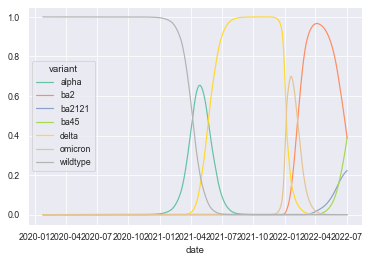

In [70]:
new_df.plot(cmap='Set2')

In [58]:
# Now, we make our new dataframe for modeled variant prevalence (new_df)

# Drop the 'none' column since we have nothing to compare this to in our observed data
#new_df = new_df.drop(columns=["none"])
new_df['data_label'] = ['modeled']*len(new_df['alpha'])
new_df['date'] = new_df.index
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 892 entries, 2020-01-24 to 2022-07-03
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   alpha       891 non-null    float64
 1   ba2         891 non-null    float64
 2   ba2121      891 non-null    float64
 3   ba45        891 non-null    float64
 4   delta       891 non-null    float64
 5   omicron     891 non-null    float64
 6   wildtype    891 non-null    float64
 7   data_label  892 non-null    object 
 8   date        892 non-null    object 
dtypes: float64(7), object(2)
memory usage: 102.0+ KB


In [59]:
# Concatenate our dataframes to make plotting with the 'hue' seaborn feature simple
all_data = pd.concat([new_df, new_obs], ignore_index=True)

In [61]:
# Set seaborn plotting template
sns.set_style('darkgrid')
sns.set_context("paper")

In [62]:
# Set other specifics about plotting like color palette and legend texts
colors = ['peru', 'cadetblue']
sns.set_palette(sns.color_palette(colors))
legend_texts = ['Modeled', 'Observed']

In [64]:
# Plot and save figure for each variant comparison
# ***Note: This will not show the plots in the jupyter notebook, but rather output them to you *main* directory
for col in all_data:
    plot = sns.lineplot(data=all_data, x='date', y=col, hue="data_label", palette=colors)
    plot.set(xlabel='Date', ylabel='Variant Prevalence (Normalized)')
    plot.set_title(f'{col} variant share')
    h,l = plot.get_legend_handles_labels()
    l = legend_texts
    plot.legend(h,l, loc=0, borderaxespad=0.,title='Data Source' ,fontsize=10)
    plot.get_figure().savefig(f"{col}_variant_share.png", dpi=300, bbox_inches = "tight")
    plt.clf()

<Figure size 432x288 with 0 Axes>